In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [3]:
class ImageTransform():    
    def __init__(self, resize, mean, std):
        # DONE transform train and val
        # self.data_trainsform - dictionary
        # __call__ -> return self.data_transform[phase](img)
        # see code in below
        self.data_transform = {'train': transforms.Compose([transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)), 
                                                            transforms.RandomHorizontalFlip(), 
                                                            transforms.ToTensor(), 
                                                            transforms.Normalize(mean, std)]), 
                               'val': transforms.Compose([transforms.Resize(256), 
                                                          transforms.CenterCrop(resize), 
                                                          transforms.ToTensor(), 
                                                          transforms.Normalize(mean, std)])}
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab\ Notebooks/Torch/chap06/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Torch/chap06/data


In [5]:
# !unzip dogs-vs-cats.zip -d dogs-vs-cats/

In [ ]:
cat_directory = 'dogs-vs-cats/Cat/'
dog_directory = 'dogs-vs-cats/Dog/'

In [28]:
# print([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])

['dogs-vs-cats/Cat/cat.0.jpg', 'dogs-vs-cats/Cat/cat.1.jpg', 'dogs-vs-cats/Cat/cat.10.jpg', 'dogs-vs-cats/Cat/cat.100.jpg', 'dogs-vs-cats/Cat/cat.101.jpg', 'dogs-vs-cats/Cat/cat.102.jpg', 'dogs-vs-cats/Cat/cat.103.jpg', 'dogs-vs-cats/Cat/cat.104.jpg', 'dogs-vs-cats/Cat/cat.105.jpg', 'dogs-vs-cats/Cat/cat.106.jpg', 'dogs-vs-cats/Cat/cat.107.jpg', 'dogs-vs-cats/Cat/cat.108.jpg', 'dogs-vs-cats/Cat/cat.109.jpg', 'dogs-vs-cats/Cat/cat.11.jpg', 'dogs-vs-cats/Cat/cat.110.jpg', 'dogs-vs-cats/Cat/cat.111.jpg', 'dogs-vs-cats/Cat/cat.112.jpg', 'dogs-vs-cats/Cat/cat.113.jpg', 'dogs-vs-cats/Cat/cat.114.jpg', 'dogs-vs-cats/Cat/cat.115.jpg', 'dogs-vs-cats/Cat/cat.116.jpg', 'dogs-vs-cats/Cat/cat.117.jpg', 'dogs-vs-cats/Cat/cat.118.jpg', 'dogs-vs-cats/Cat/cat.119.jpg', 'dogs-vs-cats/Cat/cat.12.jpg', 'dogs-vs-cats/Cat/cat.120.jpg', 'dogs-vs-cats/Cat/cat.121.jpg', 'dogs-vs-cats/Cat/cat.122.jpg', 'dogs-vs-cats/Cat/cat.123.jpg', 'dogs-vs-cats/Cat/cat.124.jpg', 'dogs-vs-cats/Cat/cat.126.jpg', 'dogs-vs-cats/

In [6]:
# DONE sorted
cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])   
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]    
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]    

random.seed(42)    
random.shuffle(correct_images_filepaths)
#train_images_filepaths = correct_images_filepaths[:20000] #성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트해보세요   
#val_images_filepaths = correct_images_filepaths[20000:-10] #훈련과 함께 검증도 늘려줘야 합니다
train_images_filepaths = correct_images_filepaths[:400]    
val_images_filepaths = correct_images_filepaths[400:-10]  
test_images_filepaths = correct_images_filepaths[-10:]    
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [7]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

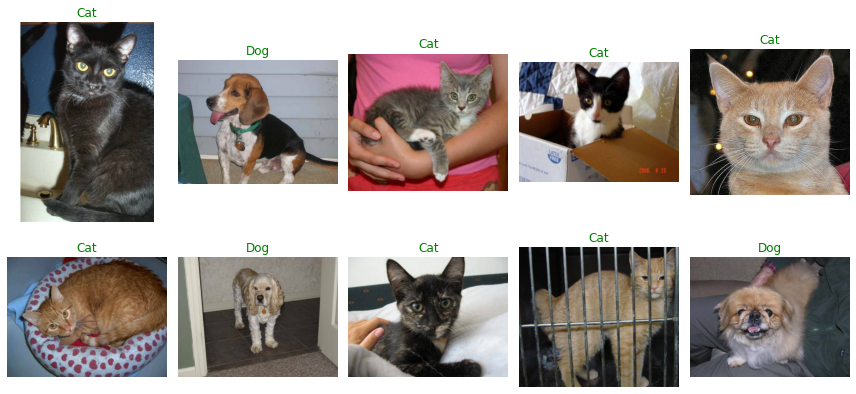

In [8]:
display_image_grid(test_images_filepaths)

In [9]:
class DogvsCatDataset(Dataset):    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):       
        img_path = self.file_list[idx]
        img = Image.open(img_path)        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [10]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

(499, 375)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


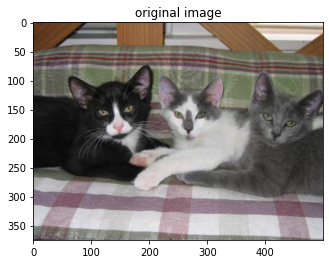


torch.Size([3, 224, 224])
<class 'torch.Tensor'>


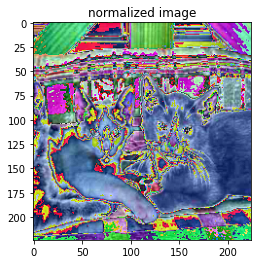


torch.Size([3, 224, 224])
<class 'torch.Tensor'>


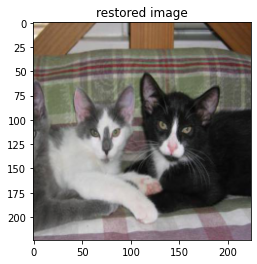

In [12]:
image_transform_sample = ImageTransform(size, mean, std)

img_path = train_images_filepaths[20]
img = Image.open(img_path)
print(img.size)
print(type(img))
plt.imshow(img)
plt.title('original image')
plt.show()
print()

img = image_transform_sample(img, phase='train')

print(img.shape)
print(type(img))
transforms_ToPIL = transforms.ToPILImage()
plt.title('normalized image')
plt.imshow(transforms_ToPIL(img))
plt.show()
print()

restored_img = torch.clone(img)
for i in range(3):
    restored_img[i, :, :] = img[i, :, :] * std[i] + mean[i]
print(restored_img.shape)
print(type(restored_img))
plt.imshow(transforms_ToPIL(restored_img))
plt.title('restored image')
plt.show()

In [29]:
# TODO ImageTransform / DogvsCatDataset / DataLoader
# ImageTransform - DONE
# DogvsCatDataset - DONE
# DataLoader - 
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

In [34]:
print(type(train_dataset))

<class '__main__.DogvsCatDataset'>


In [30]:
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [31]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 1])


In [15]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # TODO layer shape - 정리 해두기
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) 
        self.relu1 = nn.ReLU() 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) 
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)         
        self.fc1 = nn.Linear(32*53*53, 512) 
        self.relu5 = nn.ReLU()         
        self.fc2 = nn.Linear(512, 2) 
        self.output = nn.Softmax(dim=1)        
    
    def forward(self, x):
        out = self.cnn1(x) 
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out) 
        out = self.relu2(out) 
        out = self.maxpool2(out) 
        out = out.view(out.size(0), -1) 
        out = self.fc1(out) 
        out = self.fc2(out)                    
        out = self.output(out)
        return out

In [16]:
model = LeNet().to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [17]:
# !pip install torchsummary

In [18]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [19]:
# TODO 파라미터 수 계산 방법
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [21]:
# TODO criterion.to(device)
model = model.to(device)
criterion = criterion.to(device)

In [22]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:           
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

In [23]:
import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6977 Acc: 0.4900


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7068 Acc: 0.4457
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6905 Acc: 0.5425


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7286 Acc: 0.4348
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6903 Acc: 0.5525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7171 Acc: 0.5217
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6857 Acc: 0.5475


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7319 Acc: 0.4457
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6863 Acc: 0.5375


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7074 Acc: 0.4891
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6705 Acc: 0.6100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6999 Acc: 0.5217
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6573 Acc: 0.6125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6873 Acc: 0.5326
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6638 Acc: 0.5925


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6944 Acc: 0.5326
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6544 Acc: 0.6275


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6840 Acc: 0.5000
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6483 Acc: 0.6425


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6879 Acc: 0.5326
Training complete in 0m 38s
Best val Acc: 0.532609


In [24]:
import pandas as pd

id_list = []
pred_list = []
_id=0
# TODO 코드 이해
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({'id': id_list, 'label': pred_list})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('LesNet.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
res.head(10)

,id,label
0,109,0.348816
1,145,0.333728
2,15,0.548000
3,162,0.449491
4,167,0.479828
5,200,0.372394
6,210,0.494283
7,211,0.491907
8,213,0.359604
9,224,0.532364


In [26]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

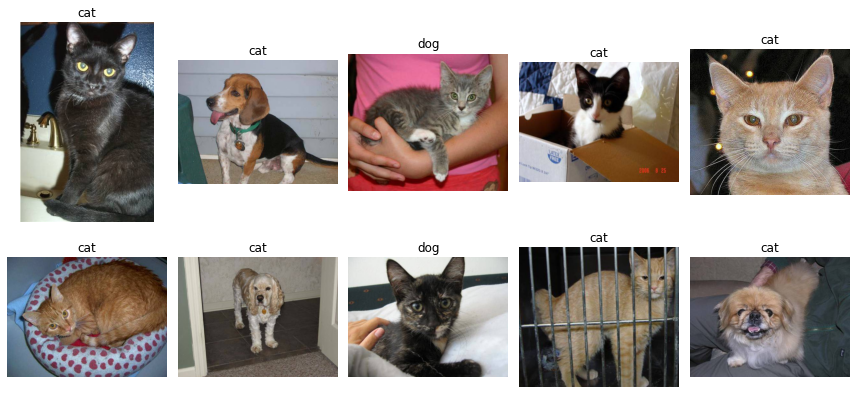

In [27]:
display_image_grid(test_images_filepaths) 